In [1]:
import gym
import tensorflow as tf
from collections import deque
import numpy as np
from random import sample, randint
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
import os
import glob
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense
from scipy.signal import savgol_filter

plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams.update({'font.size': 14})

In [2]:
'''
convenience functions
'''

def smooth(y, window, poly=1):
    '''
    y: vector to be smoothed 
    window: size of the smoothing window '''
    return savgol_filter(y,window,poly)

def save_data(data, ep_num, ep, lr, gamma):
    if ep_num > ep:
        temp = data[-1]
        temp = np.pad(temp,(0,ep_num-len(temp)),mode = 'constant',constant_values = (np.nan))
        data[-1] = temp
    fname = "reinforce_v1_lr"+"{:.4f}".format(lr)[-4:]+"_g"+"{:.4f}".format(gamma)[-4:]+"_runs{:1d}_eps".format(runs)+str(ep_num)+".csv"
    np.savetxt(fname, data, delimiter = "," )
    print("data saved in file {}".format(fname))
    if ep_num == ep:
        plot_smoothed_scores(score_stack)
        
def plot_smoothed_scores(data, save = 1, fname = "demo.pdf"):
    for run, scores in enumerate(data):
        avg_score_hist = smooth(scores,smoothen_over)
        plt.plot(avg_score_hist, label = "run "+str(run+1))
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    avg = np.nanmean(data, axis = 0)
    plt.plot(avg, label = "average over "+str(len(data))+" runs")
    plt.legend()
    if save:
        plt.savefig(fname)
    plt.show()

cwd = os.getcwd()
if cwd == "/content":
    from google.colab import drive
print("cwd is :", cwd)
def printdocs(pname):
    exec("print("+str(pname)+".__doc__)")

if cwd == "/content":
    drive.mount('/content/drive')
    !ls /content/drive/MyDrive/data/RLA3_data
    %cd /content/drive/MyDrive/data/RLA3_data
    from Helper import argmax, softmax
else:
    print("cwd is :", cwd)

print("argmax docs :", argmax.__doc__)
print("softmax docs :", softmax.__doc__)

In [3]:
class policy_network(keras.Model):
    def __init__(self, n_states, n_actions, ):
        super().__init__()
        self.n_actions = n_actions
        self.ip = keras.layers.Flatten(input_shape = n_states)
        self.l1 = keras.layers.Dense(24, kernel_initializer = tf.keras.initializers.HeUniform(seed=None), activation="relu")
        self.l2 = keras.layers.Dense(24, kernel_initializer = tf.keras.initializers.HeUniform(seed=None), activation="relu")
        self.l3 = keras.layers.Dense(24, kernel_initializer = tf.keras.initializers.HeUniform(seed=None), activation="relu")
        self.op = keras.layers.Dense(n_actions, activation="softmax")
#     def __init__(self, n_actions, fc1_dims=256, fc2_dims=256):
#         super(policy_network, self).__init__()
#         self.fc1_dims = fc1_dims
#         self.fc2_dims = fc2_dims
#         self.n_actions = n_actions

#         self.fc1 = Dense(self.fc1_dims, activation='relu')
#         self.fc2 = Dense(self.fc2_dims, activation='relu')
#         self.pi = Dense(n_actions, activation='softmax')

    def call(self, state, ):
        fp = self.ip(state)
        fp = self.l1(fp)
        fp = self.l2(fp)
        fp = self.l3(fp)
        policy = self.op(fp)
        return policy

#     def call(self, state):
#         value = self.fc1(state)
#         value = self.fc2(value)

#         pi = self.pi(value)

#         return pi

In [4]:
class agent():
    def __init__(self, n_actions, n_states, lr = 0.003, gamma = 0.99,  ):
        self.lr = lr
        self.gamma = gamma
        self.n_actions = n_actions
        self.n_states = n_states
        self.states = []
        self.actions = []
        self.rewards = []
        self.pi = policy_network(n_states = self.n_states, n_actions = n_actions)                    # check
#         self.pi = policy_network(n_actions = n_actions)
        self.pi.compile(optimizer = keras.optimizers.Adam(learning_rate = self.lr))                  # check

    def get_act(self, state, ):
        '''takes a state and returns a tensor of action categorical probabilities'''
        state_t = tf.convert_to_tensor([state], dtype = tf.float32)
        probs = self.pi(state_t)
        cat_probs = tfp.distributions.Categorical(probs = probs)
        action = cat_probs.sample()
#         print(action.numpy()[0])
        
        return action.numpy()[0]
    
#         state = tf.convert_to_tensor([observation], dtype=tf.float32)
#         probs = self.policy(state)
#         action_probs = tfp.distributions.Categorical(probs=probs)
#         action = action_probs.sample()
#         print(action.numpy()[0])
#         return action.numpy()

    def remember(self, state, action, reward, ):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def learn(self):
        actions_t = tf.convert_to_tensor(self.actions, dtype = tf.float32)
        rewards_arr = np.array(self.rewards)

        returns = np.zeros_like(rewards_arr)
        for state_id in range(returns.shape[-1]):
            returns_ds = 0
            discount_factor = 1
            for state_id_ds in range(state_id, returns.shape[-1]):
                returns_ds += rewards_arr[state_id_ds]*discount_factor
                discount_factor *= self.gamma
                
            returns[state_id] = returns_ds

        with tf.GradientTape() as tape:
            loss = 0
            for state_id, (return_g, state_g) in enumerate(zip(returns, self.states)):
                state_g = tf.convert_to_tensor([state_g], dtype = tf.float32)
                probabilities = self.pi(state_g)
                action_probabilities = tfp.distributions.Categorical(probs = probabilities)
                log_probabilities = action_probabilities.log_prob(actions_t[state_id])
                loss += -return_g * tf.squeeze(log_probabilities)

        grad = tape.gradient(loss, self.pi.trainable_variables)
        self.pi.optimizer.apply_gradients(zip(grad, self.pi.trainable_variables))

        self.states = []
        self.actions = []
        self.rewards = []


In [5]:
# learnrate = 0.001
# gam = 0.99
# runs = 8
# ep_num = 2000
# save_data_cadence = 200
# smoothen_over = 11
# if save_data_cadence>ep_num:
#     print("WARNING : data will not get saved if save cadence is more than ep_num")


# testing
learnrate = 0.001
gam = 0.99
runs = 8
ep_num = 300
save_data_cadence = 100
smoothen_over = 11
if save_data_cadence>ep_num:
    print("WARNING : data will not get saved if save cadence is more than ep_num")





beginning run number 0
episode:  0 score: 32.0 , average score 32.0
episode:  1 score: 13.0 , average score 22.5
episode:  2 score: 33.0 , average score 26.0
episode:  3 score: 37.0 , average score 28.8
episode:  4 score: 25.0 , average score 28.0
episode:  5 score: 24.0 , average score 27.3
episode:  6 score: 37.0 , average score 28.7
episode:  7 score: 23.0 , average score 28.0
episode:  8 score: 14.0 , average score 26.4
episode:  9 score: 41.0 , average score 27.9
episode:  10 score: 28.0 , average score 27.9
episode:  11 score: 38.0 , average score 28.8
episode:  12 score: 30.0 , average score 28.8
episode:  13 score: 18.0 , average score 28.1
episode:  14 score: 25.0 , average score 27.9
episode:  15 score: 52.0 , average score 29.4
episode:  16 score: 29.0 , average score 29.4
episode:  17 score: 29.0 , average score 29.3
episode:  18 score: 18.0 , average score 28.7
episode:  19 score: 13.0 , average score 27.9
episode:  20 score: 24.0 , average score 27.8
episode:  21 scor

episode:  175 score: 28.0 , average score 58.6
episode:  176 score: 65.0 , average score 58.8
episode:  177 score: 90.0 , average score 59.4
episode:  178 score: 189.0 , average score 60.9
episode:  179 score: 72.0 , average score 61.1
episode:  180 score: 47.0 , average score 61.1
episode:  181 score: 197.0 , average score 62.2
episode:  182 score: 111.0 , average score 63.0
episode:  183 score: 45.0 , average score 63.2
episode:  184 score: 70.0 , average score 63.4
episode:  185 score: 106.0 , average score 63.7
episode:  186 score: 71.0 , average score 64.0
episode:  187 score: 86.0 , average score 64.8
episode:  188 score: 79.0 , average score 65.3
episode:  189 score: 53.0 , average score 65.5
episode:  190 score: 112.0 , average score 66.3
episode:  191 score: 36.0 , average score 66.6
episode:  192 score: 70.0 , average score 66.9
episode:  193 score: 81.0 , average score 67.2
episode:  194 score: 50.0 , average score 67.2
episode:  195 score: 68.0 , average score 67.5
episode:

episode:  46 score: 41.0 , average score 28.5
episode:  47 score: 47.0 , average score 28.9
episode:  48 score: 20.0 , average score 28.7
episode:  49 score: 40.0 , average score 28.9
episode:  50 score: 31.0 , average score 29.0
episode:  51 score: 57.0 , average score 29.5
episode:  52 score: 48.0 , average score 29.9
episode:  53 score: 25.0 , average score 29.8
episode:  54 score: 36.0 , average score 29.9
episode:  55 score: 32.0 , average score 29.9
episode:  56 score: 95.0 , average score 31.1
episode:  57 score: 76.0 , average score 31.8
episode:  58 score: 98.0 , average score 33.0
episode:  59 score: 71.0 , average score 33.6
episode:  60 score: 79.0 , average score 34.3
episode:  61 score: 82.0 , average score 35.1
episode:  62 score: 83.0 , average score 35.9
episode:  63 score: 47.0 , average score 36.0
episode:  64 score: 139.0 , average score 37.6
episode:  65 score: 55.0 , average score 37.9
episode:  66 score: 32.0 , average score 37.8
episode:  67 score: 60.0 , averag

episode:  216 score: 237.0 , average score 144.8
episode:  217 score: 136.0 , average score 144.6
episode:  218 score: 182.0 , average score 145.0
episode:  219 score: 288.0 , average score 147.1
episode:  220 score: 138.0 , average score 147.6
episode:  221 score: 230.0 , average score 148.5
episode:  222 score: 162.0 , average score 149.3
episode:  223 score: 136.0 , average score 149.4
episode:  224 score: 117.0 , average score 149.9
episode:  225 score: 57.0 , average score 150.2
episode:  226 score: 142.0 , average score 151.0
episode:  227 score: 54.0 , average score 150.6
episode:  228 score: 159.0 , average score 151.6
episode:  229 score: 147.0 , average score 151.7
episode:  230 score: 183.0 , average score 152.8
episode:  231 score: 225.0 , average score 153.3
episode:  232 score: 442.0 , average score 156.5
episode:  233 score: 102.0 , average score 157.2
episode:  234 score: 106.0 , average score 156.1
episode:  235 score: 120.0 , average score 156.2
episode:  236 score: 2

episode:  88 score: 58.0 , average score 25.4
episode:  89 score: 16.0 , average score 25.3
episode:  90 score: 32.0 , average score 25.4
episode:  91 score: 37.0 , average score 25.5
episode:  92 score: 61.0 , average score 25.9
episode:  93 score: 83.0 , average score 26.5
episode:  94 score: 52.0 , average score 26.8
episode:  95 score: 41.0 , average score 26.9
episode:  96 score: 29.0 , average score 27.0
episode:  97 score: 43.0 , average score 27.1
episode:  98 score: 67.0 , average score 27.5
episode:  99 score: 18.0 , average score 27.4
data saved in file reinforce_v1_lr0010_g9900_runs8_eps300.csv
episode:  100 score: 73.0 , average score 28.0
episode:  101 score: 30.0 , average score 28.2
episode:  102 score: 53.0 , average score 28.6
episode:  103 score: 92.0 , average score 29.3
episode:  104 score: 40.0 , average score 29.6
episode:  105 score: 65.0 , average score 30.1
episode:  106 score: 22.0 , average score 30.1
episode:  107 score: 53.0 , average score 30.5
episode:  

episode:  259 score: 64.0 , average score 109.3
episode:  260 score: 38.0 , average score 108.8
episode:  261 score: 23.0 , average score 108.5
episode:  262 score: 138.0 , average score 108.9
episode:  263 score: 24.0 , average score 108.4
episode:  264 score: 169.0 , average score 109.4
episode:  265 score: 31.0 , average score 108.8
episode:  266 score: 118.0 , average score 109.2
episode:  267 score: 184.0 , average score 110.3
episode:  268 score: 180.0 , average score 110.1
episode:  269 score: 112.0 , average score 110.4
episode:  270 score: 179.0 , average score 111.3
episode:  271 score: 131.0 , average score 112.2
episode:  272 score: 22.0 , average score 112.0
episode:  273 score: 113.0 , average score 112.1
episode:  274 score: 148.0 , average score 112.7
episode:  275 score: 115.0 , average score 113.2
episode:  276 score: 254.0 , average score 114.8
episode:  277 score: 109.0 , average score 115.4
episode:  278 score: 53.0 , average score 115.5
episode:  279 score: 86.0 ,

episode:  132 score: 27.0 , average score 21.7
episode:  133 score: 59.0 , average score 22.2
episode:  134 score: 36.0 , average score 22.3
episode:  135 score: 21.0 , average score 22.4
episode:  136 score: 46.0 , average score 22.7
episode:  137 score: 32.0 , average score 22.9
episode:  138 score: 26.0 , average score 23.0
episode:  139 score: 103.0 , average score 23.9
episode:  140 score: 46.0 , average score 24.3
episode:  141 score: 119.0 , average score 25.3
episode:  142 score: 9.0 , average score 25.3
episode:  143 score: 22.0 , average score 25.4
episode:  144 score: 59.0 , average score 25.8
episode:  145 score: 12.0 , average score 25.6
episode:  146 score: 51.0 , average score 25.8
episode:  147 score: 33.0 , average score 25.9
episode:  148 score: 84.0 , average score 26.7
episode:  149 score: 39.0 , average score 26.9
episode:  150 score: 26.0 , average score 27.1
episode:  151 score: 72.0 , average score 27.7
episode:  152 score: 27.0 , average score 27.8
episode:  15

episode:  3 score: 45.0 , average score 28.8
episode:  4 score: 15.0 , average score 26.0
episode:  5 score: 20.0 , average score 25.0
episode:  6 score: 25.0 , average score 25.0
episode:  7 score: 22.0 , average score 24.6
episode:  8 score: 21.0 , average score 24.2
episode:  9 score: 17.0 , average score 23.5
episode:  10 score: 8.0 , average score 22.1
episode:  11 score: 26.0 , average score 22.4
episode:  12 score: 34.0 , average score 23.3
episode:  13 score: 17.0 , average score 22.9
episode:  14 score: 16.0 , average score 22.4
episode:  15 score: 10.0 , average score 21.6
episode:  16 score: 37.0 , average score 22.5
episode:  17 score: 28.0 , average score 22.8
episode:  18 score: 14.0 , average score 22.4
episode:  19 score: 18.0 , average score 22.1
episode:  20 score: 36.0 , average score 22.8
episode:  21 score: 16.0 , average score 22.5
episode:  22 score: 19.0 , average score 22.3
episode:  23 score: 25.0 , average score 22.5
episode:  24 score: 21.0 , average score 2

episode:  177 score: 230.0 , average score 104.8
episode:  178 score: 59.0 , average score 105.0
episode:  179 score: 119.0 , average score 105.6
episode:  180 score: 106.0 , average score 105.9
episode:  181 score: 210.0 , average score 107.2
episode:  182 score: 88.0 , average score 107.7
episode:  183 score: 277.0 , average score 110.2
episode:  184 score: 115.0 , average score 111.0
episode:  185 score: 175.0 , average score 112.3
episode:  186 score: 111.0 , average score 112.2
episode:  187 score: 75.0 , average score 112.5
episode:  188 score: 107.0 , average score 112.9
episode:  189 score: 101.0 , average score 112.4
episode:  190 score: 55.0 , average score 111.7
episode:  191 score: 178.0 , average score 113.1
episode:  192 score: 107.0 , average score 113.0
episode:  193 score: 258.0 , average score 115.3
episode:  194 score: 89.0 , average score 115.2
episode:  195 score: 221.0 , average score 116.1
episode:  196 score: 232.0 , average score 116.5
episode:  197 score: 82.0

episode:  45 score: 37.0 , average score 21.5
episode:  46 score: 28.0 , average score 21.6
episode:  47 score: 10.0 , average score 21.4
episode:  48 score: 10.0 , average score 21.1
episode:  49 score: 20.0 , average score 21.1
episode:  50 score: 52.0 , average score 21.7
episode:  51 score: 31.0 , average score 21.9
episode:  52 score: 27.0 , average score 22.0
episode:  53 score: 26.0 , average score 22.1
episode:  54 score: 23.0 , average score 22.1
episode:  55 score: 8.0 , average score 21.8
episode:  56 score: 30.0 , average score 22.0
episode:  57 score: 15.0 , average score 21.9
episode:  58 score: 34.0 , average score 22.1
episode:  59 score: 55.0 , average score 22.6
episode:  60 score: 40.0 , average score 22.9
episode:  61 score: 18.0 , average score 22.8
episode:  62 score: 27.0 , average score 22.9
episode:  63 score: 16.0 , average score 22.8
episode:  64 score: 17.0 , average score 22.7
episode:  65 score: 11.0 , average score 22.5
episode:  66 score: 25.0 , average 

episode:  216 score: 45.0 , average score 120.1
episode:  217 score: 90.0 , average score 120.0
episode:  218 score: 165.0 , average score 121.3
episode:  219 score: 251.0 , average score 123.6
episode:  220 score: 204.0 , average score 125.4
episode:  221 score: 190.0 , average score 127.1
episode:  222 score: 179.0 , average score 127.3
episode:  223 score: 307.0 , average score 129.6
episode:  224 score: 378.0 , average score 132.9
episode:  225 score: 269.0 , average score 134.7
episode:  226 score: 167.0 , average score 135.2
episode:  227 score: 144.0 , average score 136.3
episode:  228 score: 123.0 , average score 136.5
episode:  229 score: 37.0 , average score 135.6
episode:  230 score: 129.0 , average score 136.3
episode:  231 score: 150.0 , average score 137.7
episode:  232 score: 183.0 , average score 138.4
episode:  233 score: 189.0 , average score 140.0
episode:  234 score: 160.0 , average score 140.5
episode:  235 score: 113.0 , average score 140.4
episode:  236 score: 21

episode:  88 score: 29.0 , average score 21.2
episode:  89 score: 16.0 , average score 21.2
episode:  90 score: 42.0 , average score 21.4
episode:  91 score: 27.0 , average score 21.4
episode:  92 score: 34.0 , average score 21.6
episode:  93 score: 40.0 , average score 21.8
episode:  94 score: 44.0 , average score 22.0
episode:  95 score: 40.0 , average score 22.2
episode:  96 score: 55.0 , average score 22.5
episode:  97 score: 15.0 , average score 22.5
episode:  98 score: 31.0 , average score 22.5
episode:  99 score: 18.0 , average score 22.5
data saved in file reinforce_v1_lr0010_g9900_runs8_eps300.csv
episode:  100 score: 28.0 , average score 22.7
episode:  101 score: 48.0 , average score 23.0
episode:  102 score: 37.0 , average score 23.2
episode:  103 score: 27.0 , average score 23.4
episode:  104 score: 88.0 , average score 24.1
episode:  105 score: 36.0 , average score 24.3
episode:  106 score: 25.0 , average score 24.4
episode:  107 score: 30.0 , average score 24.6
episode:  

episode:  260 score: 25.0 , average score 57.1
episode:  261 score: 59.0 , average score 57.0
episode:  262 score: 46.0 , average score 57.0
episode:  263 score: 48.0 , average score 56.8
episode:  264 score: 34.0 , average score 56.4
episode:  265 score: 46.0 , average score 56.4
episode:  266 score: 32.0 , average score 56.2
episode:  267 score: 137.0 , average score 57.0
episode:  268 score: 73.0 , average score 57.3
episode:  269 score: 33.0 , average score 57.0
episode:  270 score: 38.0 , average score 56.3
episode:  271 score: 80.0 , average score 56.8
episode:  272 score: 94.0 , average score 56.9
episode:  273 score: 189.0 , average score 58.1
episode:  274 score: 43.0 , average score 58.2
episode:  275 score: 40.0 , average score 57.8
episode:  276 score: 76.0 , average score 58.3
episode:  277 score: 23.0 , average score 58.2
episode:  278 score: 99.0 , average score 58.3
episode:  279 score: 16.0 , average score 58.2
episode:  280 score: 106.0 , average score 58.4
episode:  

episode:  133 score: 154.0 , average score 79.5
episode:  134 score: 108.0 , average score 80.2
episode:  135 score: 60.0 , average score 80.4
episode:  136 score: 107.0 , average score 81.3
episode:  137 score: 52.0 , average score 81.6
episode:  138 score: 149.0 , average score 82.7
episode:  139 score: 205.0 , average score 84.0
episode:  140 score: 193.0 , average score 85.7
episode:  141 score: 174.0 , average score 87.1
episode:  142 score: 144.0 , average score 88.1
episode:  143 score: 98.0 , average score 88.4
episode:  144 score: 150.0 , average score 89.7
episode:  145 score: 59.0 , average score 90.1
episode:  146 score: 126.0 , average score 90.8
episode:  147 score: 98.0 , average score 91.1
episode:  148 score: 182.0 , average score 92.3
episode:  149 score: 103.0 , average score 92.9
episode:  150 score: 117.0 , average score 93.6
episode:  151 score: 198.0 , average score 95.0
episode:  152 score: 112.0 , average score 96.0
episode:  153 score: 122.0 , average score 97

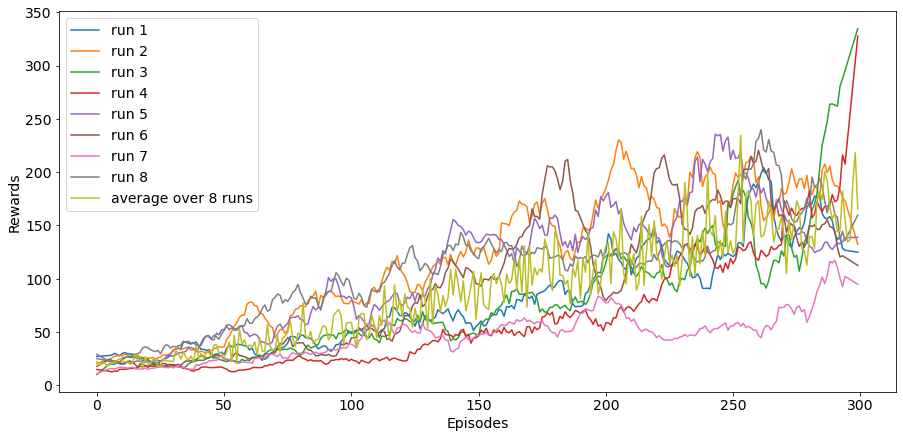

In [6]:
if __name__ == "__main__":
    
    score_stack = []
    # run loop
    for run_num in range(runs):
        
        print("\n\n\n\nbeginning run number {}".format(run_num))

        # initialise environment
        env = gym.make('CartPole-v1')

        # initialize agent
        agent_007 = agent(lr = learnrate, gamma = gam, n_actions = env.action_space.n, n_states = env.observation_space.shape)

        # list to maintain score
        score_hist = []
        score_stack.append(score_hist)
        
        # episode loop
        for ep in range(ep_num):
            done = False
            score = 0
            s = env.reset()

            # step loop
            while not done:
                a = agent_007.get_act(s)
                s_next,reward,done,_ = env.step(a)
                agent_007.remember(s,a,reward)
                s = s_next
                score += reward
#                 env.render()

            # append score to score list
            score_hist.append(score)

            # make agent learn
            agent_007.learn()
            avg_score = np.mean(score_hist[-100:])
            print('episode: ', ep,'score: %.1f' % score,
                ', average score %.1f' % avg_score)

            if (ep+1) % save_data_cadence == 0:
                score_stack[-1] = score_hist
                save_data(score_stack, ep_num, ep, learnrate, gam)

plot_smoothed_scores(score_stack)